In [6]:
import pandas as pd
import numpy as np

from sklearn.linear_model import Lasso

from energy_consumption.feature_selection.extract import extract_energy_data, extract_all_features
from energy_consumption.help_functions import get_forecast_timestamps, create_submission_frame
from energy_consumption.help_functions import drop_years
from energy_consumption.models.lasso.functions import get_quantiles, get_interaction_and_pol_terms


def get_Lasso_forecasts(energydata=pd.DataFrame(), indexes=[47, 51, 55, 71, 75, 79],
                        quantiles=[0.025, 0.25, 0.5, 0.75, 0.975], periods=100, abs_eval=False):

    if energydata.empty:
        # use derived optimum for number of years (see notebook)
        energydata = extract_energy_data.get_data(num_years=6.17)
    if len(energydata) > 54027:
        energydata = energydata[-54027:]

    # get standardized features
    energydata = extract_all_features.get_energy_and_standardized_features2(energydata,lasso=True)

    # split df
    y = energydata[['energy_consumption']]
    X = energydata.drop(columns=['energy_consumption'])
    X.insert(loc=0, column='constant', value=1)
    X = get_interaction_and_pol_terms(X)

    # create dataframe to store forecast quantiles
    X_fc = get_forecast_timestamps.forecast_timestamps(
        energydata.index[-1])
    X_fc = extract_all_features.get_energy_and_standardized_features2(X_fc, lasso=True)
    X_fc = get_interaction_and_pol_terms(X_fc)
    X_fc.insert(loc=0, column='constant', value=1)
    print(X_fc.columns)

    # drop years
    X, X_fc = drop_years.drop_years(X, X_fc)

    # fit Lasso Regression with best alpha
    lasso = Lasso(alpha=0.0547)

    # Fit the model on the scaled data
    lasso.fit(X, y)

    # estimate forecast means
    mean_est = lasso.predict(X_fc).flatten()

    # estimate quantile forecasts
    quantile_forecasts = get_quantiles(
        mean_est, quantiles).iloc[indexes]

    # return quantile forecasts in terms of absolute evaluation
    if abs_eval == True:
        horizon = pd.date_range(start=energydata.index[-1] + pd.DateOffset(
            hours=1), periods=periods, freq='H')
        quantile_forecasts.insert(
            0, 'date_time', [horizon[i] for i in indexes])

        return quantile_forecasts

    # else: create submission frame
    else:
        forecast_frame = create_submission_frame.get_frame(
            quantile_forecasts, indexes)
        forecast_frame = forecast_frame.drop(columns={'index'})
        horizon = pd.date_range(start=energydata.index[-1] + pd.DateOffset(
            hours=1), periods=periods, freq='H')
        forecast_frame.insert(
            0, 'date_time', [horizon[i] for i in indexes])

        return forecast_frame

In [19]:
import pandas as pd
from energy_consumption.feature_selection.clean.impute_outliers import impute_outliers
energydata = pd.read_csv(
    'c:\\Users\\Maria\\Documents\\Studium\\Pyhton Projekte\\PTSFC\\energy_consumption\\feature_selection\\data\\historical_data.csv')
energydata['date_time'] = pd.to_datetime(
    energydata['date_time'], format='%Y-%m-%d %H:%M:%S')
energydata = energydata.set_index("date_time")
energydata = impute_outliers(energydata)

In [9]:
forecasts = get_Lasso_forecasts(energydata)
forecasts

did you update weather and index?
2017-09-23 10:00:00
2023-11-23 12:00:00
did you update weather and index?
2023-11-22 13:00:00
2023-11-27 16:00:00


,date_time,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2023-11-24 12:00:00,2024-01-22,energy,36 hour,56.129296,60.585269,63.710612,65.261377,69.717350
1,2023-11-24 16:00:00,2024-01-22,energy,40 hour,52.089673,56.772861,60.017424,61.687409,66.370597
2,2023-11-24 20:00:00,2024-01-22,energy,44 hour,50.463347,55.265962,58.573188,60.305837,65.108453
3,2023-11-25 12:00:00,2024-01-22,energy,60 hour,50.754223,55.395138,58.617520,60.265324,64.906240
4,2023-11-25 16:00:00,2024-01-22,energy,64 hour,47.066866,51.703957,54.924332,56.570130,61.207220
5,2023-11-25 20:00:00,2024-01-22,energy,68 hour,45.301548,50.149226,53.480096,55.236390,60.084068


In [19]:
pit_merged = pd.DataFrame(columns=['date_time', 'q0.1', 'q0.2', 'q0.3', 'q0.4', 'q0.5', 'q0.6',
                                   'q0.7', 'q0.8', 'q0.9', 'energy_consumption'])
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# extend range to get more accurate results
for i in range(1, 10):
    print(f'start of round {i}')
    forecasts = get_Lasso_forecasts(energydata[:i*-168],
                                       indexes=list(range(80)),
                                       quantiles=quantiles, abs_eval=True)
    obs = energydata[i*(-168):i*(-168)+80].reset_index()
    forecasts_obs = forecasts.merge(obs, how='left', on='date_time')
    pit_merged = pd.concat([pit_merged, forecasts_obs])

# Insert a column 'q1' with inf values after 'q0.9'
column_index = pit_merged.columns.get_loc('q0.9') + 1
if 'q1' not in pit_merged.columns:
    pit_merged.insert(column_index, 'q1', float('inf'))

start of round 1
did you update weather and index?
2017-09-16 10:00:00
2023-11-16 12:00:00
did you update weather and index?
2023-11-15 13:00:00
2023-11-20 16:00:00
start of round 2
did you update weather and index?
2017-09-09 10:00:00
2023-11-09 12:00:00
did you update weather and index?
2023-11-08 13:00:00
2023-11-13 16:00:00
start of round 3
did you update weather and index?
2017-09-02 10:00:00
2023-11-02 12:00:00
did you update weather and index?
2023-11-01 13:00:00
2023-11-06 16:00:00
start of round 4
did you update weather and index?
2017-08-26 10:00:00
2023-10-26 12:00:00
did you update weather and index?
2023-10-25 13:00:00
2023-10-30 16:00:00
start of round 5
did you update weather and index?
2017-08-19 10:00:00
2023-10-19 12:00:00
did you update weather and index?
2023-10-18 13:00:00
2023-10-23 16:00:00
start of round 6
did you update weather and index?
2017-08-12 10:00:00
2023-10-12 12:00:00
did you update weather and index?
2023-10-11 13:00:00
2023-10-16 16:00:00
start of r

In [20]:
pit_merged 

,date_time,q0.1,q0.2,q0.3,q0.4,q0.5,q0.6,q0.7,q0.8,q0.9,q1,energy_consumption
0,2023-11-15 13:00:00,56.446375,57.861140,58.881285,59.752961,61.354985,61.382431,62.254107,63.274252,64.689017,inf,65.83350
1,2023-11-15 14:00:00,54.927693,56.407349,57.474285,58.385942,60.025335,60.090150,61.001808,62.068744,63.548399,inf,63.93950
2,2023-11-15 15:00:00,53.891674,55.454801,56.581926,57.545012,59.232474,59.345360,60.308446,61.435570,62.998697,inf,63.17325
3,2023-11-15 16:00:00,53.531585,55.090425,56.214459,57.174904,58.859898,58.970315,59.930760,61.054794,62.613634,inf,64.27325
4,2023-11-15 17:00:00,54.986621,56.403842,57.425759,58.298949,59.902387,59.931248,60.804438,61.826355,63.243577,inf,66.69150
...,...,...,...,...,...,...,...,...,...,...,...,...
75,2023-09-23 16:00:00,51.029519,52.616480,53.760790,54.738560,56.439748,56.566358,57.544129,58.688439,60.275399,inf,46.67975
76,2023-09-23 17:00:00,52.438022,53.888868,54.935030,55.828937,57.451739,57.499964,58.393871,59.440033,60.890879,inf,46.99475
77,2023-09-23 18:00:00,52.764384,54.288958,55.388283,56.327616,57.992877,58.083560,59.022893,60.122218,61.646792,inf,47.87775
78,2023-09-23 19:00:00,52.041547,53.605928,54.733957,55.697816,57.386001,57.499608,58.463467,59.591496,61.155878,inf,48.10275


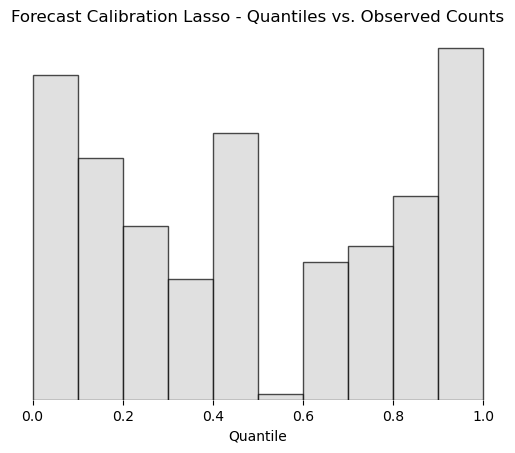

In [22]:
import matplotlib.pyplot as plt 

def find_first_quantile(row):
    quantile_columns = [f'q{quantile}' for quantile in quantiles]
    for quantile_col in quantile_columns:
        if row['energy_consumption'] < row[quantile_col]:
            return quantile_col
    return 'q1'


# Apply the function to each row
pit_merged['first_quantile'] = pit_merged.apply(find_first_quantile, axis=1)
quantile_counts = pit_merged['first_quantile'].value_counts()

# order quantiles for final plot
ordered_quantile_counts = {}
for q in quantiles:
    if f'q{q}' in quantile_counts.index:
        ordered_quantile_counts[q] = quantile_counts.loc[f'q{q}']
    else:
        ordered_quantile_counts[q] = 0

counts = list(ordered_quantile_counts.values())

bar_width = 0.1
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# Centering the bars on the left-hand side of their ticks
plt.bar([q - bar_width for q in quantiles], counts,
        width=bar_width, color='lightgrey', alpha=0.7, align='edge', edgecolor='black')
plt.xlabel('Quantile')
plt.yticks([])
# Alternatively: observed counts in each quantile range
plt.title('Forecast Calibration Lasso - Quantiles vs. Observed Counts')
plt.box(False)
plt.show()

Zeigt: Quantile sind zu klein geschätzt!
Forschritt: Keine Schiefe Verteilung mehr
Verteilung der Residuen betrachten

In [2]:
import pandas as pd
import numpy as np

from scipy.stats import t
from math import sqrt

def get_quantiles(mean_est, quantiles=[0.025, 0.25, 0.5, 0.75, 0.975]):

    mean_est = np.array(mean_est)
    quantile_df = pd.DataFrame()

    # lasso variance
    residuals = pd.read_csv(
        'c:\\Users\\Maria\\Documents\\Studium\\Pyhton Projekte\\PTSFC\\energy_consumption\\models\\lasso\\residuals.csv')
    residual_std = np.sqrt(residuals.var(axis=0))

    # add variance due to forecasts of regressors
    std_to_add = sqrt(0.10246283393337681)

    for q in quantiles:
        if q < 0.5:
            quantile_df[f'q{q}'] = mean_est + \
                residual_std * t.ppf(q, df=1) - std_to_add
        elif q == 0.5:
            quantile_df[f'q{q}'] = mean_est
        else:
            quantile_df[f'q{q}'] = mean_est + \
                residual_std * t.ppf(q, df=1) - std_to_add

    return quantile_df

In [22]:
import pandas as pd
residuals = pd.read_csv(
    'c:\\Users\\Maria\\Documents\\Studium\\Pyhton Projekte\\PTSFC\\energy_consumption\\models\\lasso\\residuals.csv')
residuals

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,2.526930,2.543000,2.315939,1.494746,0.437093,-0.906118,-1.495215,-3.850543,-5.606979,-5.470258,...,-0.381244,-1.077724,-1.398273,-1.003983,-1.245431,-0.784669,0.331112,1.542933,2.083121,2.254678
1,1.989862,1.676488,2.029536,4.442175,2.360988,2.092679,2.310442,2.220621,2.009556,0.343765,...,0.763575,0.562785,1.048888,0.505404,0.372558,-0.534903,-2.182189,-4.739814,-5.602265,7.015951
2,4.995251,4.699385,4.651356,4.333308,3.632008,1.268759,0.032776,-0.458155,-0.040107,0.054828,...,9.443414,8.511861,6.934722,5.334970,5.294280,6.115802,4.439596,4.247730,4.264952,4.355653
3,4.200311,4.107323,3.906747,3.321685,3.272063,3.552950,3.333103,2.702632,2.873957,2.533993,...,1.870816,4.346728,2.112337,2.015033,2.172084,2.416965,1.867137,-0.749101,-2.141677,-2.458489
4,-2.106325,-2.175920,-2.449474,-2.754942,-2.431062,-1.872491,-1.519343,-0.914488,0.198800,1.243765,...,-3.943490,-2.966872,-0.326946,2.540694,3.867445,3.043272,1.171185,0.372841,0.181037,0.296819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,4.045330,3.924840,4.155051,4.000760,3.915291,3.399044,2.962766,5.921149,4.452081,4.193631,...,2.378115,1.652533,2.335534,2.315031,1.557891,0.183630,-2.290289,-2.774279,-2.497817,-2.933359
301,-4.341169,-6.059202,-7.991361,4.219868,1.822957,1.777355,1.307476,1.114685,-0.431350,-4.612140,...,-2.555840,-3.242049,-4.333923,-3.079304,-2.665780,-2.114787,-0.990668,0.097048,0.669139,0.933290
302,0.013559,-0.240005,-0.258219,-0.486853,-1.840454,-4.644888,-5.820988,-4.859913,-3.523838,-3.280876,...,-5.322813,-4.163391,-3.829152,-2.838315,-2.916457,1.279613,-0.596830,-1.073894,-1.372358,-1.625742
303,-3.804577,-7.347635,-6.976894,-6.945825,-6.402319,-6.503571,-5.922994,-5.649461,-5.260273,-4.465171,...,1.902454,-4.704259,-6.160203,-5.806375,-5.099995,-4.265438,-2.270993,1.158950,2.930690,2.370259


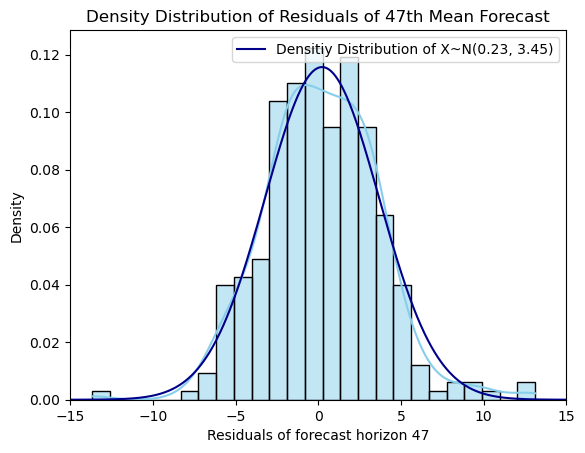

In [37]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, t

# Your existing data
array_47 = np.array(residuals.iloc[:, 47])
std_47 = round(np.std(residuals.iloc[:, 47]),2)
mean_47 = round(np.mean(residuals.iloc[:, 47]),2)

# Create a density plot using seaborn
sns.histplot(array_47, kde=True, stat="density", color="skyblue", bins=25)

# Add labels and title
plt.xlabel('Residuals of forecast horizon 47')
plt.xlim(-15, 15)
plt.ylabel('Density')
plt.title('Density Distribution of Residuals of 47th Mean Forecast')

# Plot standard normal distribution (mean=0, std=1)
x = np.linspace(-15, 15, 1000)
plt.plot(x, norm.pdf(x, mean_47, std_47), label=f'Densitiy Distribution of X~N({mean_47}, {std_47})', color='darkblue')

# Show legend
plt.legend()

# Show the plot
plt.show()

In [174]:
def get_quantiles(mean_est, quantiles=[0.025, 0.25, 0.5, 0.75, 0.975]):

    mean_est = np.array(mean_est)
    quantile_df = pd.DataFrame()

    # lasso variance
    residuals = pd.read_csv(
        'c:\\Users\\Maria\\Documents\\Studium\\Pyhton Projekte\\PTSFC\\energy_consumption\\models\\lasso\\residuals2.csv')
    mean_residuals = np.array(residuals.mean(axis=0))
    std_dev_residuals = np.array(residuals.std(axis=0))

    mean_corr = np.array(mean_est) - mean_residuals

    # add variance due to forecasts of regressors
    std_to_add = sqrt(0.10246)

    for q in quantiles:
        if q < 0.5:
            quantile_df[f'q{q}'] = mean_corr + \
                std_dev_residuals*norm.ppf(q, loc=0) - std_to_add
        else:
            quantile_df[f'q{q}'] = mean_corr + \
                std_dev_residuals*norm.ppf(q, loc=0) + std_to_add

    return quantile_df

In [151]:
norm.ppf(0.5, loc=0)

0.0

In [152]:
residuals = pd.read_csv(
    'c:\\Users\\Maria\\Documents\\Studium\\Pyhton Projekte\\PTSFC\\energy_consumption\\models\\lasso\\residuals2.csv')
mean_residuals = np.array(residuals.mean(axis=0))
mean_residuals

array([ 1.79267828e-02,  6.39256611e-03, -4.75191727e-02, -2.53264211e-01,
        2.47689762e-02, -4.75077478e-03, -3.97306047e-02, -2.77652501e-01,
        1.12854021e-03,  3.01003968e-02, -2.87283059e-04, -3.27032085e-01,
       -9.31882616e-02, -9.60418355e-02, -1.17840830e-01, -3.86679087e-01,
       -9.12589548e-02, -7.71487049e-02, -4.81011324e-02, -2.51036312e-01,
        4.02167728e-02,  6.84384912e-02,  5.71527048e-02, -1.89377385e-01,
        1.23442729e-01,  1.14700179e-01,  9.66601067e-02, -1.66176937e-01,
        5.54454171e-02,  1.87118094e-02, -1.11474972e-02, -3.80678923e-01,
       -8.33645485e-02, -1.88943525e-01, -1.17328705e-01, -3.09757812e-01,
       -2.67981550e-02, -2.39172523e-02, -1.16332235e-02, -2.48993196e-01,
        1.07152699e-02, -1.42781365e-03, -2.93802411e-02, -2.24455215e-01,
        8.47212037e-02,  4.77012554e-02,  7.90254690e-02, -2.13920436e-01,
        6.01738449e-02,  2.30796281e-02,  2.77455603e-03, -3.01961875e-01,
        2.60746460e-02, -

In [173]:
import pandas as pd
import numpy as np

from sklearn.linear_model import Lasso

from energy_consumption.feature_selection.extract import extract_energy_data, extract_all_features
from energy_consumption.help_functions import get_forecast_timestamps, create_submission_frame
from energy_consumption.help_functions import drop_years
from energy_consumption.models.lasso.functions import get_quantiles, get_interaction_and_pol_terms


def get_Lasso_forecasts(energydata=pd.DataFrame(), indexes=[47, 51, 55, 71, 75, 79],
                        quantiles=[0.025, 0.25, 0.5, 0.75, 0.975], periods=100, abs_eval=False):

    if energydata.empty:
        # use derived optimum for number of years (see notebook)
        energydata = extract_energy_data.get_data()

    # get standardized features
    energydata = extract_all_features.get_energy_and_standardized_features2(energydata,
                                                                           lasso=True)

    # split df
    y = energydata[['energy_consumption']]
    X = energydata.drop(columns=['energy_consumption'])
    X.insert(loc=0, column='constant', value=1)
    X = get_interaction_and_pol_terms(X)

    # create dataframe to store forecast quantiles
    X_fc = get_forecast_timestamps.forecast_timestamps(
        energydata.index[-1])
    X_fc = extract_all_features.get_energy_and_standardized_features2(
        X_fc, lasso=True)
    X_fc = get_interaction_and_pol_terms(X_fc)
    X_fc.insert(loc=0, column='constant', value=1)

    # drop years
    X, X_fc = drop_years.drop_years(X, X_fc)

    # fit Lasso Regression with best alpha
    lasso = Lasso(alpha=0.006)

    # Fit the model on the scaled data
    lasso.fit(X, y)

    # estimate forecast means
    mean_est = lasso.predict(X_fc).flatten()

    # estimate quantile forecasts
    quantile_forecasts = get_quantiles(
        mean_est, quantiles).iloc[indexes]

    # return quantile forecasts in terms of absolute evaluation
    if abs_eval == True:
        horizon = pd.date_range(start=energydata.index[-1] + pd.DateOffset(
            hours=1), periods=periods, freq='H')
        quantile_forecasts.insert(
            0, 'date_time', [horizon[i] for i in indexes])

        return quantile_forecasts

    # else: create submission frame
    else:
        forecast_frame = create_submission_frame.get_frame(
            quantile_forecasts, indexes)
        forecast_frame = forecast_frame.drop(columns={'index'})
        horizon = pd.date_range(start=energydata.index[-1] + pd.DateOffset(
            hours=1), periods=periods, freq='H')
        forecast_frame.insert(
            0, 'date_time', [horizon[i] for i in indexes])

        return forecast_frame

In [175]:
import pandas as pd
from energy_consumption.feature_selection.clean.impute_outliers import impute_outliers
energydata = pd.read_csv(
    'c:\\Users\\Maria\\Documents\\Studium\\Pyhton Projekte\\PTSFC\\energy_consumption\\feature_selection\\data\\historical_data.csv')
energydata['date_time'] = pd.to_datetime(
    energydata['date_time'], format='%Y-%m-%d %H:%M:%S')
energydata = energydata.set_index("date_time")
energydata = impute_outliers(energydata)

In [177]:
pit_merged = pd.DataFrame(columns=['date_time', 'q0.1', 'q0.2', 'q0.3', 'q0.4', 'q0.5', 'q0.6',
                                   'q0.7', 'q0.8', 'q0.9', 'energy_consumption'])
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# extend range to get more accurate results
for i in range(1, 10):
    print(f'start of round {i}')
    forecasts = get_Lasso_forecasts(energydata[:i*-168],
                                    indexes=list(range(80)),
                                    quantiles=quantiles, abs_eval=True)
    obs = energydata[i*(-168):i*(-168)+80].reset_index()
    forecasts_obs = forecasts.merge(obs, how='left', on='date_time')
    pit_merged = pd.concat([pit_merged, forecasts_obs])

# Insert a column 'q1' with inf values after 'q0.9'
column_index = pit_merged.columns.get_loc('q0.9') + 1
if 'q1' not in pit_merged.columns:
    pit_merged.insert(column_index, 'q1', float('inf'))

start of round 1
did you update weather and index?
2016-12-26 00:00:00
2023-11-16 12:00:00
did you update weather and index?
2023-11-15 13:00:00
2023-11-20 16:00:00
start of round 2
did you update weather and index?
2016-12-26 00:00:00
2023-11-09 12:00:00
did you update weather and index?
2023-11-08 13:00:00
2023-11-13 16:00:00
start of round 3
did you update weather and index?
2016-12-26 00:00:00
2023-11-02 12:00:00
did you update weather and index?
2023-11-01 13:00:00
2023-11-06 16:00:00
start of round 4
did you update weather and index?
2016-12-26 00:00:00
2023-10-26 12:00:00
did you update weather and index?
2023-10-25 13:00:00
2023-10-30 16:00:00
start of round 5
did you update weather and index?
2016-12-26 00:00:00
2023-10-19 12:00:00
did you update weather and index?
2023-10-18 13:00:00
2023-10-23 16:00:00
start of round 6
did you update weather and index?
2016-12-26 00:00:00
2023-10-12 12:00:00
did you update weather and index?
2023-10-11 13:00:00
2023-10-16 16:00:00
start of r

In [178]:
import matplotlib.pyplot as plt


def find_first_quantile(row):
    quantile_columns = [f'q{quantile}' for quantile in quantiles]
    for quantile_col in quantile_columns:
        if row['energy_consumption'] < row[quantile_col]:
            return quantile_col
    return 'q1'


# Apply the function to each row
pit_merged['first_quantile'] = pit_merged.apply(find_first_quantile, axis=1)
quantile_counts = pit_merged['first_quantile'].value_counts()

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# order quantiles for final plot
ordered_quantile_counts = {}
for q in quantiles:
    if f'q{q}' in quantile_counts.index:
        ordered_quantile_counts[q] = quantile_counts.loc[f'q{q}']
    else:
        ordered_quantile_counts[q] = 0

counts = list(ordered_quantile_counts.values())
ordered_quantile_counts

{0.1: 72,
 0.2: 73,
 0.3: 64,
 0.4: 61,
 0.5: 89,
 0.6: 57,
 0.7: 65,
 0.8: 80,
 0.9: 83,
 1: 76}

In [179]:
pit_merged

,date_time,q0.1,q0.2,q0.3,q0.4,q0.5,q0.6,q0.7,q0.8,q0.9,q1,energy_consumption,first_quantile
0,2023-11-15 13:00:00,57.220081,58.628410,59.643915,60.511626,61.962842,62.773871,63.641582,64.657087,66.065416,inf,65.83350,q0.9
1,2023-11-15 14:00:00,55.728051,57.192263,58.248064,59.150206,60.633604,61.476815,62.378958,63.434758,64.898970,inf,63.93950,q0.9
2,2023-11-15 15:00:00,54.755065,56.294490,57.404524,58.353007,59.879718,60.766242,61.714725,62.824759,64.364184,inf,63.17325,q0.9
3,2023-11-15 16:00:00,54.572882,56.103818,57.207730,58.150982,59.672805,60.554440,61.497692,62.601604,64.132540,inf,64.27325,q1
4,2023-11-15 17:00:00,55.630367,57.050744,58.074936,58.950070,60.408224,61.226190,62.101324,63.125516,64.545893,inf,66.69150,q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2023-09-23 16:00:00,51.153121,52.708617,53.830240,54.788625,56.324591,57.220371,58.178756,59.300378,60.855875,inf,46.67975,q0.1
76,2023-09-23 17:00:00,52.173684,53.629261,54.678835,55.575657,57.054082,57.892320,58.789142,59.838716,61.294293,inf,46.99475,q0.1
77,2023-09-23 18:00:00,52.549742,54.076898,55.178085,56.119009,57.638655,58.518113,59.459037,60.560224,62.087380,inf,47.87775,q0.1
78,2023-09-23 19:00:00,51.830488,53.415156,54.557814,55.534172,57.086939,57.999518,58.975876,60.118534,61.703202,inf,48.10275,q0.1


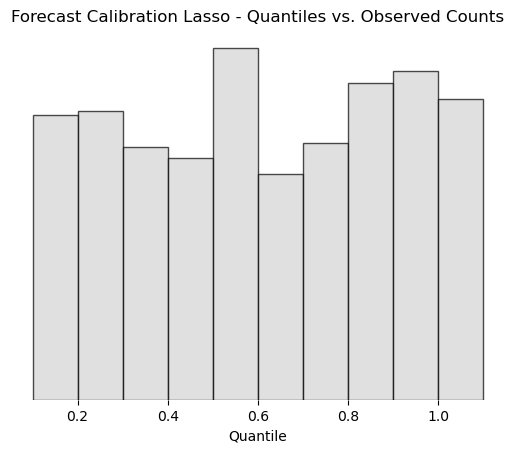

In [180]:
bar_width = 0.1
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# Centering the bars on the left-hand side of their ticks
plt.bar(quantiles, counts,
        width=bar_width, color='lightgrey', alpha=0.7, align='edge', edgecolor='black')
plt.xlabel('Quantile')
plt.yticks([])
# Alternatively: observed counts in each quantile range
plt.title('Forecast Calibration Lasso - Quantiles vs. Observed Counts')
plt.box(False)
plt.show()

Note: I am aware that biased due to same data set